<a href="https://colab.research.google.com/github/Alf-caput/NonVerbalAudioClassifier/blob/main/src/tensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
import os

zip_filename = 'vs_release_16k.zip'

if not os.path.exists(zip_filename):
    os.system("wget https://www.dropbox.com/s/fuld3z222j9t1oy/vs_release_16k.zip")

Dentro de vs_release_16k.zip descomprimimos:  
- audio_16k  

Nos servimos del módulo zipfile para descomprimir.  

In [84]:
import os
from zipfile import ZipFile
from concurrent.futures import ThreadPoolExecutor

zip_filename = 'vs_release_16k.zip'
audio_dir = 'audio_16k/'

if not os.path.exists(audio_dir):
    with ZipFile(zip_filename, 'r') as zf:
        with ThreadPoolExecutor() as exe:
            for file in zf.namelist():
                if file.startswith(audio_dir):
                    exe.submit(zf.extract, file)

In [85]:
import tensorflow as tf

audio_dir = 'audio_16k/'
seed = 42

tf.random.set_seed(seed)

ds_files = tf.data.Dataset.list_files(audio_dir + '*.wav') # by default shuffle=True

print("Total audios:", len(ds_files))
print("Filenames shape:", ds_files.element_spec)

Total audios: 21023
Filenames shape: TensorSpec(shape=(), dtype=tf.string, name=None)


In [86]:
for elem in ds_files.take(5):
    print(elem)

tf.Tensor(b'audio_16k\\f1349_0_laughter.wav', shape=(), dtype=string)
tf.Tensor(b'audio_16k\\m2715_0_laughter.wav', shape=(), dtype=string)
tf.Tensor(b'audio_16k\\f0663_0_laughter.wav', shape=(), dtype=string)
tf.Tensor(b'audio_16k\\f2375_0_cough.wav', shape=(), dtype=string)
tf.Tensor(b'audio_16k\\f2620_0_cough.wav', shape=(), dtype=string)


In [87]:
vocal_sounds = ['cough', 'laughter', 'sigh', 'sneeze', 'sniff', 'throatclearing']
num_sounds = len(vocal_sounds)

for elem in ds_files.take(1):
    example_file = elem

def get_label(file_path):
  label = tf.strings.split(
    input=file_path,
    sep='_')[-1]

  label = tf.strings.split(
    input=label,
    sep='.')[0]

  label = tf.where(label==vocal_sounds)
  label = tf.reshape(label, ())
  return label

print("Filename Tensor:", example_file)
print("Label Tensor:", get_label(example_file))

Filename Tensor: tf.Tensor(b'audio_16k\\f2076_0_laughter.wav', shape=(), dtype=string)
Label Tensor: tf.Tensor(1, shape=(), dtype=int64)


In [88]:
std_len = 64000

for elem in ds_files.take(1):
    example_file = elem

def get_signal(file_path):
  audio_binary = tf.io.read_file(file_path)
  signal = tf.audio.decode_wav(audio_binary)[0]
  signal = signal[:std_len]
  signal = tf.pad(signal, [[0, std_len-len(signal)], [0, 0]])
  return tf.squeeze(signal, axis=-1)

print("Filename Tensor:", example_file)
print("Signal Tensor:", get_signal(example_file))

Filename Tensor: tf.Tensor(b'audio_16k\\f3351_0_sniff.wav', shape=(), dtype=string)
Signal Tensor: tf.Tensor(
[-0.00012207  0.          0.00021362 ...  0.          0.
  0.        ], shape=(64000,), dtype=float32)


In [79]:
AUTOTUNE = tf.data.AUTOTUNE

ds_signals = (
    ds_files
    .shuffle(len(ds_files))
    .cache()
    .map(lambda x: (get_signal(x), get_label(x)), num_parallel_calls=AUTOTUNE)
    )

print("Total signals:", len(ds_signals))
print("Signals shape:", ds_signals.element_spec)

Total signals: 21023
Signals shape: (TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


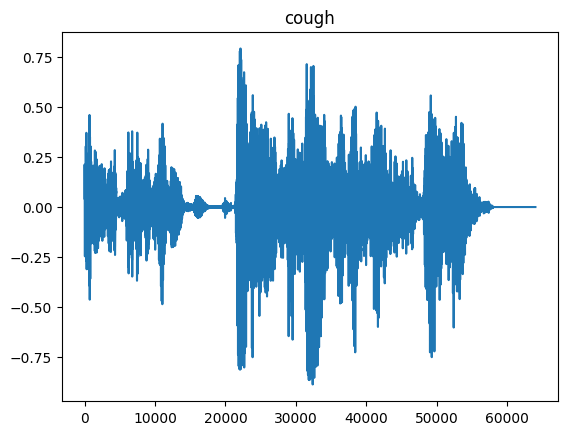

In [82]:
import matplotlib.pyplot as plt
for elem in ds_signals.take(1):
  signal, label = elem
  plt.plot(signal)
  plt.title(vocal_sounds[label])

In [8]:
def remove_shortaudio(filename):
  if get_signal(filename).shape[0] < min_len:
    tf.io.gfile.remove(filename)

initial_file_count = 21024

if len(filenames) >= initial_file_count:
  # Remove less than 0.1s audios (16kHz then 1600 frames)
  min_len = 1600
  with ThreadPoolExecutor() as exe:
    for file in filenames:
      exe.submit(remove_shortaudio, file)

  filenames = tf.io.gfile.glob(audio_dir + '*')

print('Total audios:', len(filenames))


Total audios: 21023


In [9]:
ds_files = tf.data.Dataset.from_tensor_slices(filenames)
ds_signals = ds_files.map(lambda x: (get_signal(x), get_label(x)), num_parallel_calls=AUTOTUNE)

In [10]:
for elem in ds_signals.take(1):
  print(elem)

(<tf.Tensor: shape=(64000,), dtype=float32, numpy=
array([ 0.0000000e+00, -3.0517578e-05,  0.0000000e+00, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [11]:
def normalize(audio, label):
  label = tf.one_hot(label, len(vocal_sounds))
  return audio, label

ds_signals = ds_signals.map(normalize).cache()

In [12]:
for elem in ds_signals.take(1):
  print(elem)

(<tf.Tensor: shape=(64000,), dtype=float32, numpy=
array([ 0.0000000e+00, -3.0517578e-05,  0.0000000e+00, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)>, <tf.Tensor: shape=(6,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 0.], dtype=float32)>)


In [13]:
ds_signals.element_spec

(TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 TensorSpec(shape=(6,), dtype=tf.float32, name=None))

In [14]:
num_train = len(ds_signals)

RATIO = 0.2
test_size = int(RATIO * num_train)

ds_train = ds_signals.skip(test_size)
ds_test = ds_signals.take(test_size)

In [15]:
num_train = len(ds_train)

RATIO = 0.2
validation_size = int(RATIO * num_train)

ds_fit = ds_signals.skip(validation_size)
ds_val = ds_signals.take(validation_size)

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 1024
ds_fit = (
    ds_fit
    .cache()
    .shuffle(len(ds_fit))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

ds_val = (
    ds_val
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=0.0001)

epoch_wait = 5
# Crear el EarlyStopping callback con la función on_train_end
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=epoch_wait)

# Definimos los callbacks
callbacks = [early_stopping, reduce_lr]

In [18]:
# Establecer la semilla global
seed_value = 42
tf.random.set_seed(seed_value)

In [19]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Arquitectura de la red convolucional
model = Sequential([
    Dense(64, activation='relu', input_shape=(64000,)),  # Capa de entrada con 64 neuronas
    Dense(32, activation='relu'),  # Capa oculta con 32 neuronas
    Dense(6, activation='sigmoid')  # Capa de salida con una neurona para clasificación binaria
])

# Compila el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Resumen de la arquitectura del modelo
model.summary()

c:\Users\alfre\Desktop\Utils\ProyectoIntegradorIII\NonVerbalAudioClassifier\.venv\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │     4,096,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,098,342 (15.63 MB)

 Trainable params: 4,098,342 (15.63 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(ds_fit, epochs=100, validation_data=ds_val, callbacks=callbacks)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 188ms/step - accuracy: 0.1666 - loss: 0.6969 - val_accuracy: 0.1710 - val_loss: 0.6586 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.4162 - loss: 0.5808 - val_accuracy: 0.1775 - val_loss: 0.5843 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.5181 - loss: 0.4557 - val_accuracy: 0.1757 - val_loss: 0.5331 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.6201 - loss: 0.3569 - val_accuracy: 0.1873 - val_loss: 0.5318 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.7109 - loss: 0.2815 - val_accuracy: 0.1995 - val_loss: 0.5476 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.8264 - loss: 0.2180 - val_accuracy: 0.2186 - val_loss: 0.5772 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.9017 - loss: 0

In [21]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Arquitectura de la red convolucional
model = Sequential([
    Dense(1024, activation='relu', input_shape=(64000,)),  # Capa de entrada con 1024 neuronas
    Dense(512, activation='relu'),  # Capa oculta con 512 neuronas
    Dense(512, activation='relu'),  # Capa oculta con 512 neuronas
    Dense(6, activation='sigmoid')  # Capa de salida con una neurona para clasificación binaria
])

# Compila el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Resumen de la arquitectura del modelo
model.summary()

history = model.fit(ds_fit, epochs=100, validation_data=ds_val, callbacks=callbacks)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 1024)           │    65,537,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,327,558 (253.02 MB)

 Trainable params: 66,327,558 (253.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.1627 - loss: 0.5726 - val_accuracy: 0.1742 - val_loss: 0.5107 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.5234 - loss: 0.4107 - val_accuracy: 0.2560 - val_loss: 0.6486 - learning_rate: 0.0010
Epoch 3/100
16/18 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8415 - loss: 0.1717

KeyboardInterrupt: 

In [ ]:
BATCH_SIZE = 128
ds_eval = (
    ds_test.cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
test_loss, test_acc = model.evaluate(ds_eval)

print('Test accuracy:', test_acc)

33/33 [==============================] - 1s 22ms/step - loss: 1.1692 - accuracy: 0.3865
Test accuracy: 0.3865366280078888
